In [703]:
import zipfile
import pandas as pd
import numpy as np,gc
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, train_test_split,GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [55]:
with zipfile.ZipFile("ieee-fraud-detection.zip","r") as z:
    f=z.open('train_identity.csv')
    train_identity = pd.read_csv(f)
train_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [357]:
train_identity.dtypes

TransactionID      int64
id_01            float64
id_02            float64
id_03            float64
id_04            float64
id_05            float64
id_06            float64
id_07            float64
id_08            float64
id_09            float64
id_10            float64
id_11            float64
id_12             object
id_13            float64
id_14            float64
id_15             object
id_16             object
id_17            float64
id_18            float64
id_19            float64
id_20            float64
id_21            float64
id_22            float64
id_23             object
id_24            float64
id_25            float64
id_26            float64
id_27             object
id_28             object
id_29             object
id_30             object
id_31             object
id_32            float64
id_33             object
id_34             object
id_35             object
id_36             object
id_37             object
id_38             object
DeviceType        object


In [54]:
with zipfile.ZipFile("ieee-fraud-detection.zip","r") as z:
    f=z.open('train_transaction.csv')
    train_transaction = pd.read_csv(f)
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
train_transaction.describe()

,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
count,590540.000000,5.905400e+05,590540.000000,590540.000000,581607.000000,588975.000000,586281.000000,524834.000000,524834.000000,238269.000000,...,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.00000,82351.000000,82351.000000,82351.000000,82351.000000
mean,0.034990,7.372311e+06,135.027176,9898.734658,362.555488,153.194925,199.278897,290.733794,86.800630,118.502180,...,0.775874,721.741883,1375.783644,1014.622782,9.807015,59.16455,28.530903,55.352422,151.160542,100.700882
std,0.183755,4.617224e+06,239.162522,4901.170153,157.793246,11.336444,41.244453,101.741072,2.690623,371.872026,...,4.727971,6217.223583,11169.275702,7955.735482,243.861391,387.62948,274.576920,668.486833,1095.034387,814.946722
min,0.000000,8.640000e+04,0.251000,1000.000000,100.000000,100.000000,100.000000,100.000000,10.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,3.027058e+06,43.321000,6019.000000,214.000000,150.000000,166.000000,204.000000,87.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,7.306528e+06,68.769000,9678.000000,361.000000,150.000000,226.000000,299.000000,87.000000,8.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.124662e+07,125.000000,14184.000000,512.000000,150.000000,226.000000,330.000000,87.000000,24.000000,...,0.000000,0.000000,25.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.581113e+07,31937.391000,18396.000000,600.000000,231.000000,237.000000,540.000000,102.000000,10286.000000,...,55.000000,160000.000000,160000.000000,160000.000000,55125.000000,55125.00000,55125.000000,104060.000000,104060.000000,104060.000000


In [96]:
with zipfile.ZipFile("ieee-fraud-detection.zip","r") as z:
    f1=z.open('test_transaction.csv')
    test_transaction = pd.read_csv(f1)
    f2=z.open('test_identity.csv')
    test_identity = pd.read_csv(f2)

In [329]:
test_transaction.head(5)

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,284.95,W,10989,360.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [97]:
print(train_transaction.shape)
print(train_identity.shape)

(590540, 394)
(144233, 41)


In [361]:
all_train=pd.merge(train_transaction,train_identity,how="left",on="TransactionID")
print(all_train.shape)
all_train["tag"]="train"
print(all_train.shape)

(590540, 434)
(590540, 435)


In [362]:
print(test_transaction.shape)
print(test_identity.shape)
all_test=pd.merge(test_transaction,test_identity,how="left",on="TransactionID")
print(all_test.shape)
all_test["tag"]="test"
print(all_test.shape)

(506691, 393)
(141907, 41)
(506691, 433)
(506691, 434)


In [365]:
all_df=pd.concat([all_train.drop(["isFraud"],axis=1),all_test],axis=0)
print(all_df.shape)

(1097231, 434)


In [366]:
y_train=train_transaction[["isFraud","TransactionID"]]#keep TransactionID here in case we sort
y_train.shape

(590540, 2)

In [ ]:
# step 0:  
#let ignore identity table first(beacause now I do not know the meaning).
#feature engineering: 393 features. how to select and derive fatures?
#train/val/test split, cross validation. AUC
#try XGBoost first to predict isFraud (logistis regression)
#evaluation: performance on both old and new credit card, perforance on both txn and spd level?

In [77]:
# for a credit card(how do we define a unique credit card), if it has multiple txns and isFraud, how does it look like?
cards=['card1','card2', 'card3', 'card4', 'card5', 'card6']
train_transaction[cards].head(5)

,card1,card2,card3,card4,card5,card6
0,13926,NaN,150.0,discover,142.0,credit
1,2755,404.0,150.0,mastercard,102.0,credit
2,4663,490.0,150.0,visa,166.0,debit
3,18132,567.0,150.0,mastercard,117.0,debit
4,4497,514.0,150.0,mastercard,102.0,credit


In [78]:
###
# Categorical Features:
# ProductCD
# card1 - card6
# addr1, addr2
# Pemaildomain Remaildomain
# M1 - M9
#
cs=["C1","C2"]
train_transaction[cs].head(5)

,C1,C2
0,1.0,1.0
1,1.0,1.0
2,1.0,1.0
3,2.0,5.0
4,1.0,1.0


In [79]:
ds=["D1","D2","D3","D4","D5","D6","D7","D8","D9","D10","D11","D12","D13","D14","D15"]
train_transaction[ds].head(5)

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15
0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0
1,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0
2,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,315.0
3,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,111.0
4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [80]:
ms=["M1","M2","M3","M4","M5","M6","M7","M8","M9"]
train_transaction[ms].head(5)

,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,T,T,T,M2,F,T,NaN,NaN,NaN
1,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN
2,T,T,T,M0,F,F,F,F,F
3,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [74]:
ads=["addr1", "addr2"]
train_transaction[ads].head(5)

,addr1,addr2
0,315.0,87.0
1,325.0,87.0
2,330.0,87.0
3,476.0,87.0
4,420.0,87.0


In [75]:
ems=["P_emaildomain", "R_emaildomain"]
train_transaction[ems].head(5)

,P_emaildomain,R_emaildomain
0,NaN,NaN
1,gmail.com,NaN
2,outlook.com,NaN
3,yahoo.com,NaN
4,gmail.com,NaN


In [56]:
cols_t = ['TransactionID', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain',
       'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
       'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8',
       'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4',
       'M5', 'M6', 'M7', 'M8', 'M9']
cols_v=["V"+str(i) for i in range(1,340)]
types={}
for v in cols_v: types[v]="float32"

In [57]:
train_transaction.shape

(590540, 394)

In [58]:
train=train_transaction[cols_t+['isFraud']+cols_v]
train.shape

(590540, 394)

In [59]:
train.head(5)

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [69]:
nans_df = train.isna()
nans_groups={}
for col in train.columns:
    nan_num = nans_df[col].sum()
    try:
        nans_groups[nan_num].append(col)
    except:
        nans_groups[nan_num]=[col]
del nans_df; x=gc.collect()

In [71]:
for k,v in nans_groups.items():
    print('####### NAN count =',k)
    print(v)

####### NAN count = 0
['TransactionID', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'isFraud']
####### NAN count = 8933
['card2']
####### NAN count = 1565
['card3']
####### NAN count = 1577
['card4']
####### NAN count = 4259
['card5']
####### NAN count = 1571
['card6']
####### NAN count = 65706
['addr1', 'addr2']
####### NAN count = 352271
['dist1']
####### NAN count = 552913
['dist2']
####### NAN count = 94456
['P_emaildomain']
####### NAN count = 453249
['R_emaildomain']
####### NAN count = 1269
['D1', 'V281', 'V282', 'V283', 'V288', 'V289', 'V296', 'V300', 'V301', 'V313', 'V314', 'V315']
####### NAN count = 280797
['D2']
####### NAN count = 262878
['D3']
####### NAN count = 168922
['D4']
####### NAN count = 309841
['D5']
####### NAN count = 517353
['D6']
####### NAN count = 551623
['D7']
####### NAN count = 515614
['D8', 'D9']
####### NAN count = 76022
['D10']
####### NAN count = 27

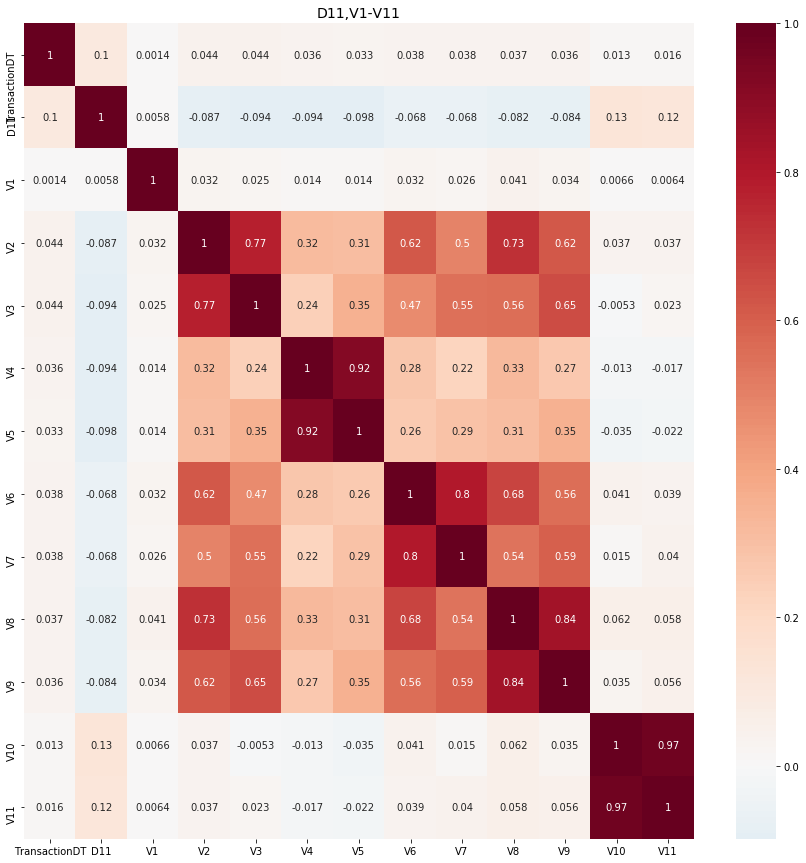

In [103]:
def make_corr(Vs,Vtitle=''):
    cols = ['TransactionDT'] + Vs
    plt.figure(figsize=(15,15))
    sns.heatmap(train[cols].corr(), cmap='RdBu_r', annot=True, center=0.0)
    plt.title(Vtitle,fontsize=14)
    plt.show()
Vs = nans_groups[279287]
Vtitle="D11,V1-V11"
make_corr(Vs,Vtitle)

In [141]:
cols_use=[]

In [142]:
grps = [[1],[2,3],[4,5],[6,7],[8,9],[10,11]]
def reduce_group(grps,c='V'):
    use = []
    for g in grps:
        mx = 0; vx = g[0]
        for gg in g:
            n = train[c+str(gg)].nunique()
            if n>mx:
                mx = n
                vx = gg
            #print(str(gg)+'-'+str(n),', ',end='')
        use.append(c+str(vx))
        cols_use.append(c+str(vx))
        #print()
    print('Use these',use)
    return cols_use
reduce_group(grps)
cols_use

Use these ['V1', 'V3', 'V4', 'V6', 'V8', 'V11']


['V1', 'V3', 'V4', 'V6', 'V8', 'V11']

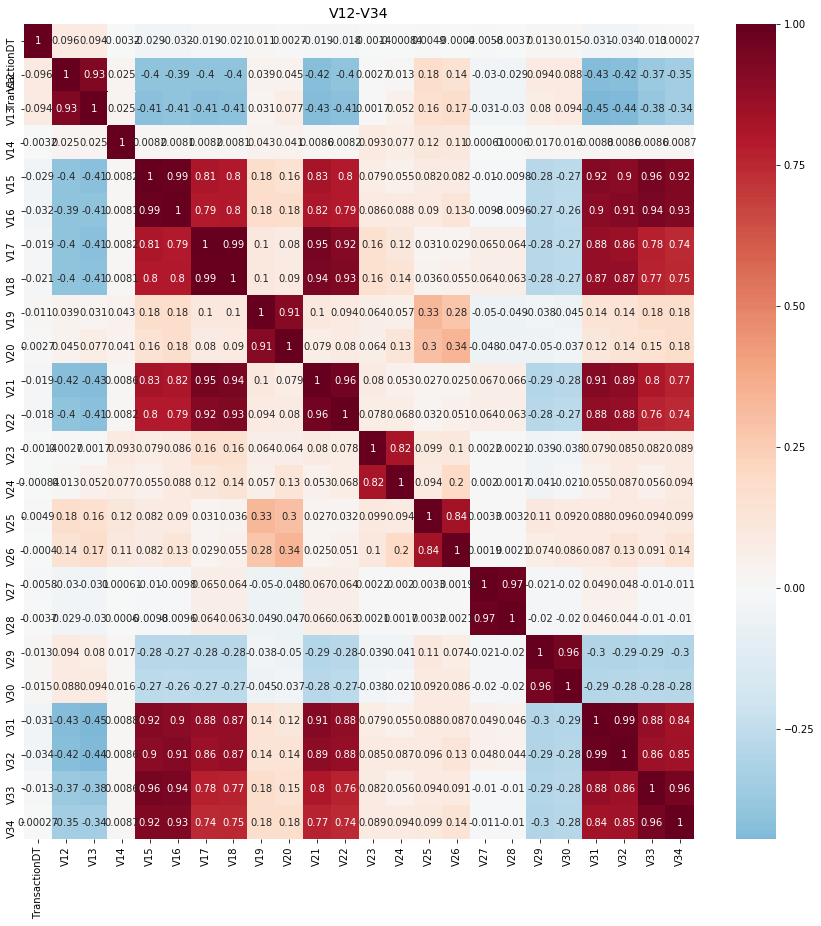

In [114]:
Vs = nans_groups[76073]
Vtitle="V12-V34" 
make_corr(Vs,Vtitle)

In [143]:
grps = [[12,13],[14],[15,16,17,18,21,22,31,32,33,34],[19,20],[23,24],[25,26],[27,28],[29,30]]
reduce_group(grps)

Use these ['V13', 'V14', 'V17', 'V20', 'V23', 'V26', 'V27', 'V30']


['V1',
 'V3',
 'V4',
 'V6',
 'V8',
 'V11',
 'V13',
 'V14',
 'V17',
 'V20',
 'V23',
 'V26',
 'V27',
 'V30']

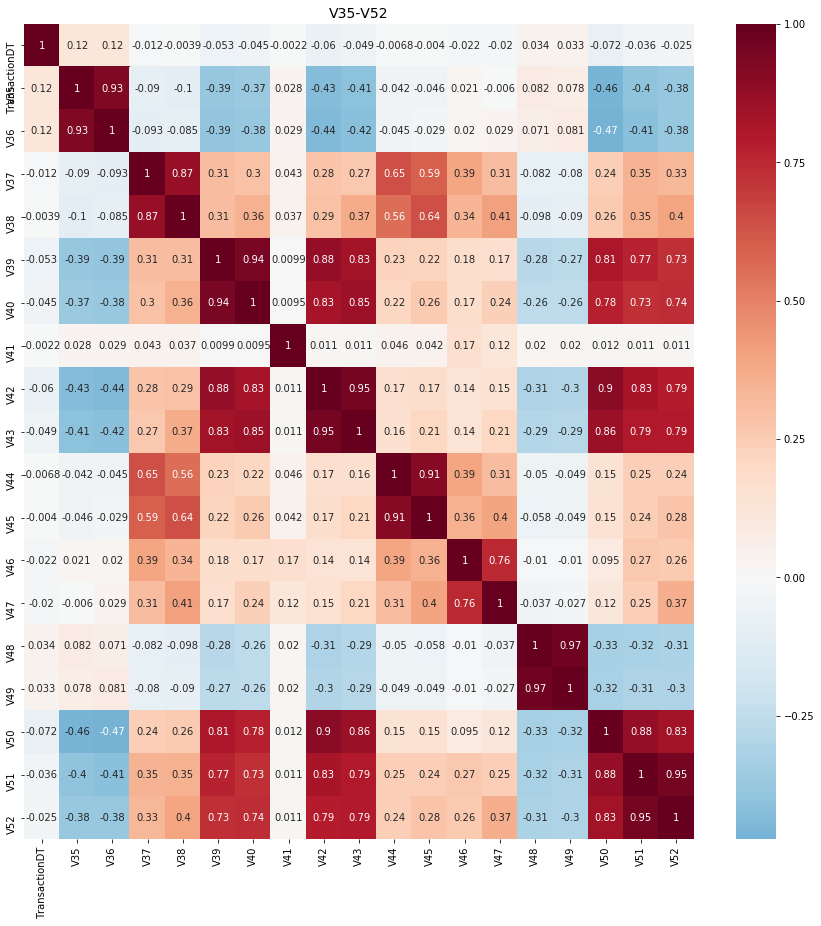

In [116]:
Vs = nans_groups[168969]
Vtitle="V35-V52"
make_corr(Vs,Vtitle)

In [144]:
grps = [[35,36],[37,38],[39,40,42,43,50,51,52],[41],[44,45],[46,47],[48,49]]
reduce_group(grps)

Use these ['V36', 'V37', 'V40', 'V41', 'V44', 'V47', 'V48']


['V1',
 'V3',
 'V4',
 'V6',
 'V8',
 'V11',
 'V13',
 'V14',
 'V17',
 'V20',
 'V23',
 'V26',
 'V27',
 'V30',
 'V36',
 'V37',
 'V40',
 'V41',
 'V44',
 'V47',
 'V48']

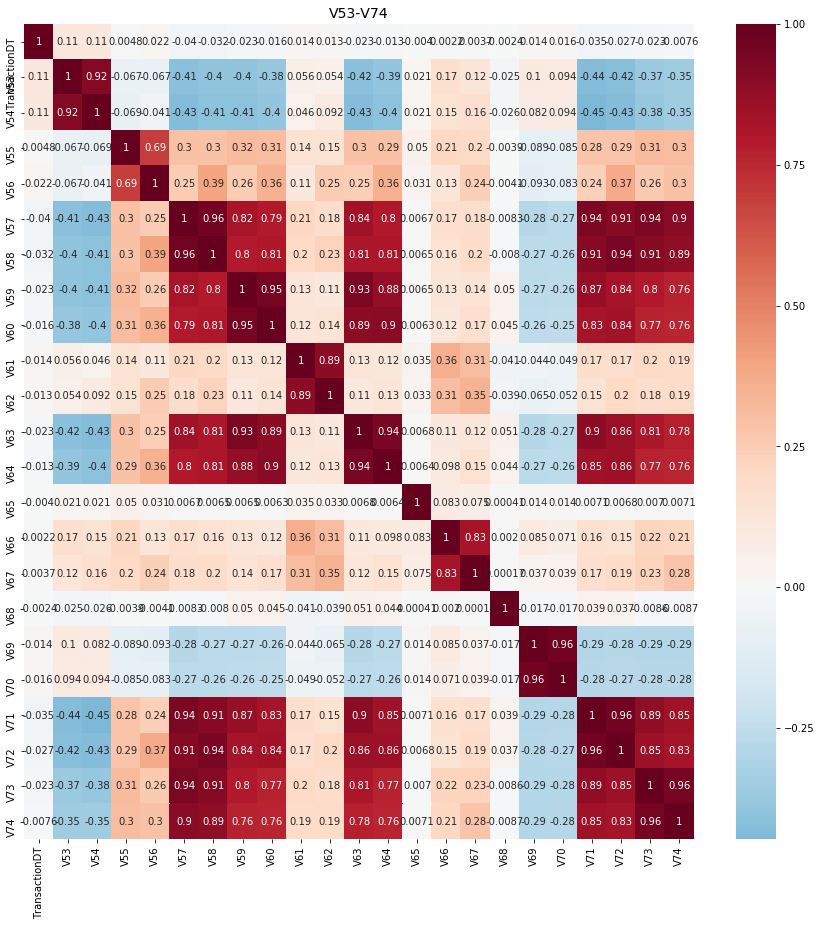

In [118]:
Vs = nans_groups[77096]
Vtitle="V53-V74"
make_corr(Vs,Vtitle)

In [145]:
grps = [[53,54],[55,56],[57,58,59,60,63,64,71,72,73,74],[61,62],[65],[66,67],[68],[69,70]]
cols_use=reduce_group(grps)

Use these ['V54', 'V56', 'V59', 'V62', 'V65', 'V67', 'V68', 'V70']


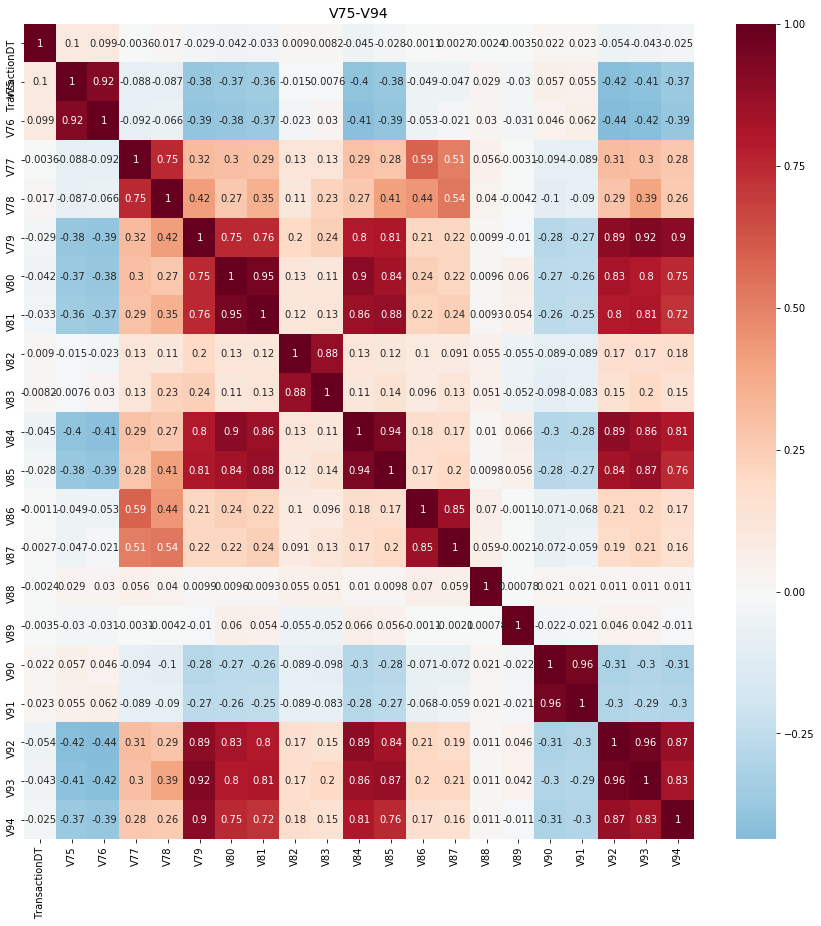

In [120]:
Vs = nans_groups[89164]
Vtitle="V75-V94"
make_corr(Vs,Vtitle)

In [146]:
grps = [[75,76],[77,78],[79,80,81,84,85,92,93,94],[82,83],[86,87],[88],[89],[90,91]]
cols_use=reduce_group(grps)

Use these ['V76', 'V78', 'V80', 'V82', 'V86', 'V88', 'V89', 'V91']


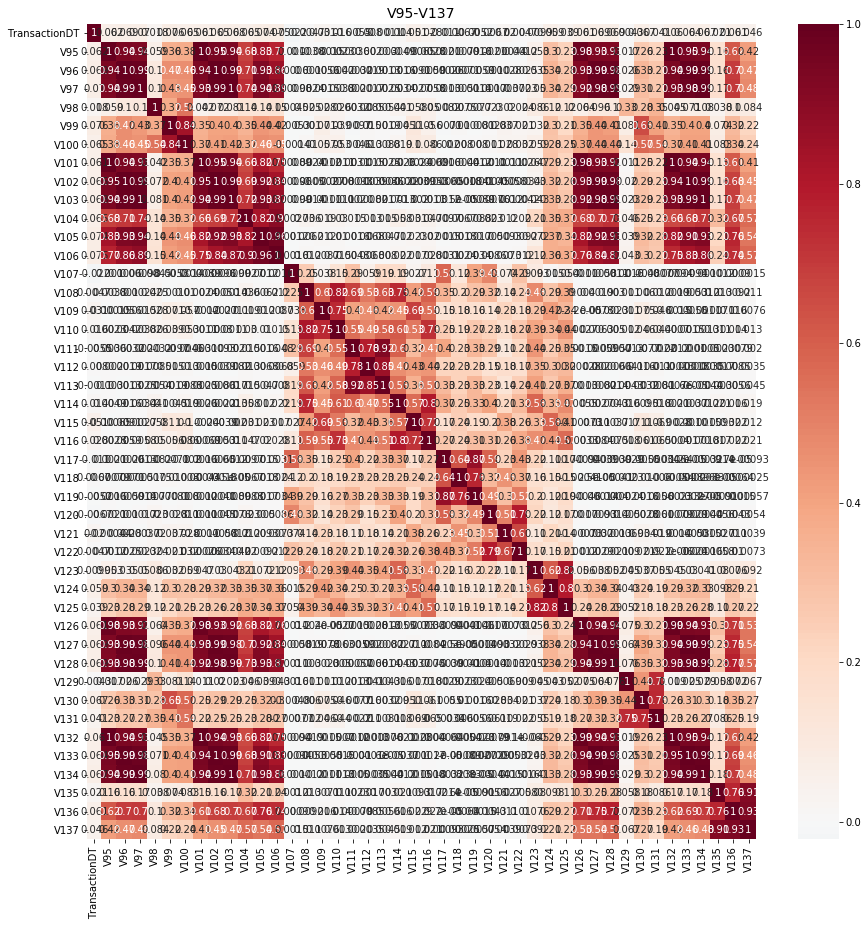

In [124]:
Vs = nans_groups[314]
Vtitle="V95-V137"
make_corr(Vs,Vtitle)

In [148]:
grps = [[95,96,97,101,102,103,105,106],[98],[99,100],[104],[107],[108,109,110,114],[111,112,113],[115,116],[117,118,119],[120,122],[121],[123],[124,125],[126,127,128,132,133,134],[129],[130,131],[135,136,137]]
cols_use=reduce_group(grps)

Use these ['V96', 'V98', 'V99', 'V104', 'V107', 'V108', 'V111', 'V115', 'V117', 'V120', 'V121', 'V123', 'V124', 'V127', 'V129', 'V130', 'V136']


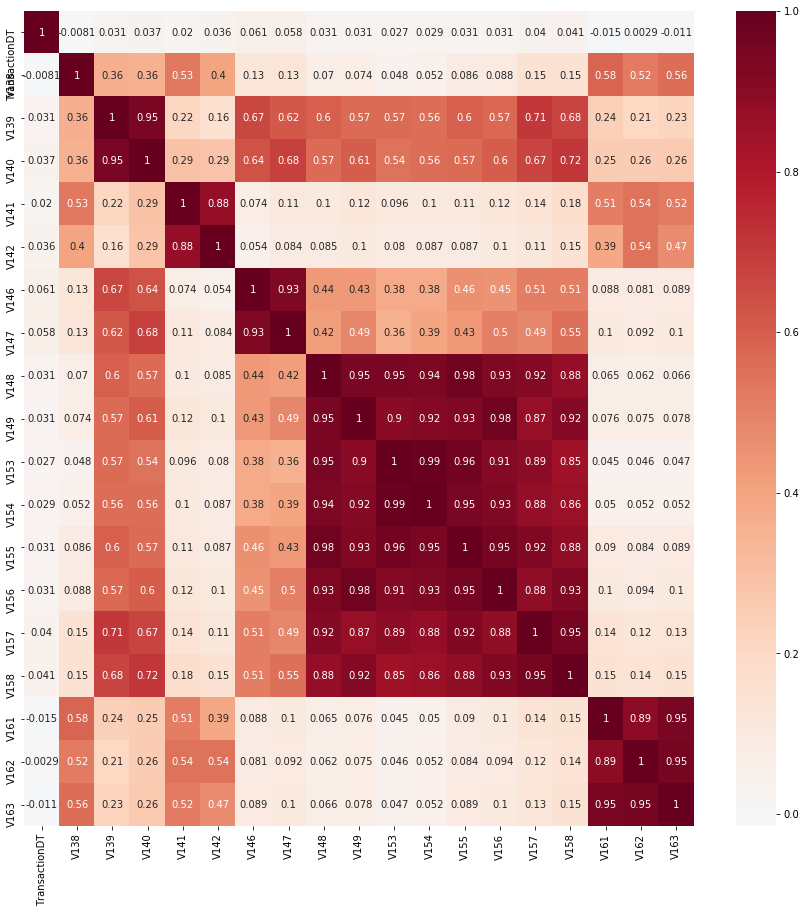

In [126]:
Vs = nans_groups[508595]
make_corr(Vs)

In [149]:
grps = [[138],[139,140],[141,142],[146,147],[148,149,153,154,156,157,158],[161,162,163]]
cols_use=reduce_group(grps)

Use these ['V138', 'V139', 'V142', 'V147', 'V156', 'V162']


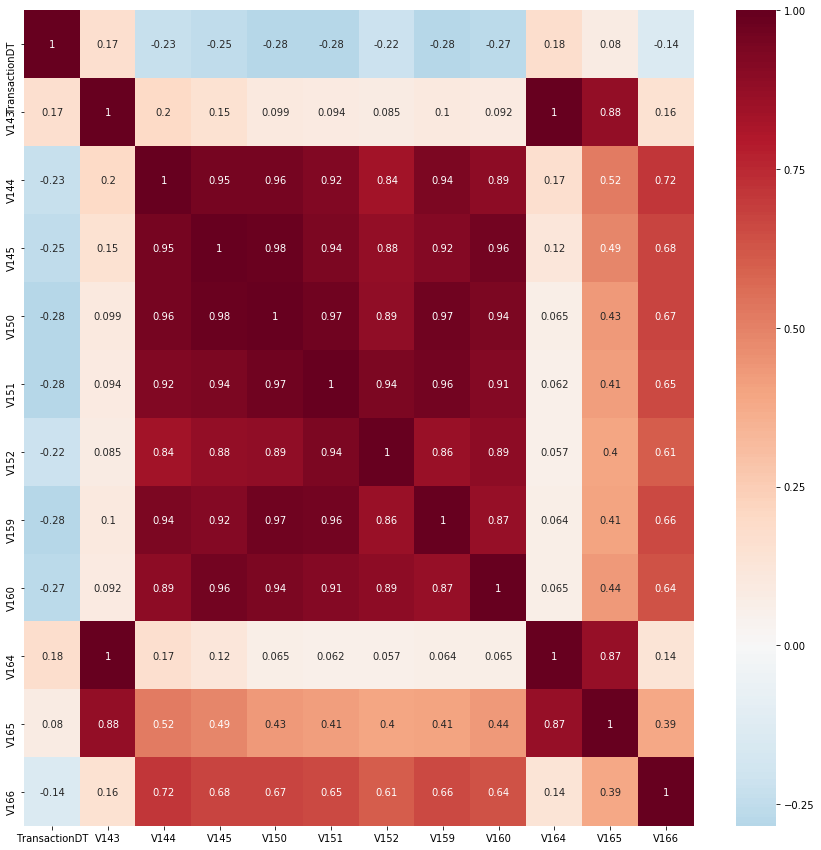

In [128]:
Vs = nans_groups[508589]
make_corr(Vs)

In [150]:
grps = [[143,164,165],[144,145,150,151,152,159,160],[166]]
cols_use=reduce_group(grps)

Use these ['V165', 'V160', 'V166']


In [153]:
grps = [[167,168,177,178,179],[172,176],[173],[181,182,183]]
reduce_group(grps)
grps = [[186,187,190,191,192,193,196,199],[202,203,204,211,212,213],[205,206],[207],[214,215,216]]
reduce_group(grps)
grps = [[169],[170,171,200,201],[174,175],[180],[184,185],[188,189],[194,195,197,198],[208,210],[209]]
reduce_group(grps)
grps = [[217,218,219,231,232,233,236,237],[223],[224,225],[226],[228],[229,230],[235]]
reduce_group(grps)
grps = [[240,241],[242,243,244,258],[246,257],[247,248,249,253,254],[252],[260],[261,262]]
reduce_group(grps)
grps = [[263,265,264],[266,269],[267,268],[273,274,275],[276,277,278]]
reduce_group(grps)
grps = [[220],[221,222,227,245,255,256,259],[234],[238,239],[250,251],[270,271,272]]
reduce_group(grps)
grps = [[279,280,293,294,295,298,299],[284],[285,287],[286],[290,291,292],[297]]
reduce_group(grps)
grps = [[302,303,304],[305],[306,307,308,316,317,318],[309,311],[310,312],[319,320,321]]
reduce_group(grps)
grps = [[281],[282,283],[288,289],[296],[300,301],[313,314,315]]
reduce_group(grps)
grps = [[322,323,324,326,327,328,329,330,331,332,333],[325],[334,335,336],[337,338,339]]
reduce_group(grps)

Use these ['V178', 'V176', 'V173', 'V182']
Use these ['V187', 'V203', 'V205', 'V207', 'V215']
Use these ['V169', 'V171', 'V175', 'V180', 'V185', 'V188', 'V198', 'V210', 'V209']
Use these ['V218', 'V223', 'V224', 'V226', 'V228', 'V229', 'V235']
Use these ['V240', 'V258', 'V257', 'V253', 'V252', 'V260', 'V261']
Use these ['V264', 'V266', 'V267', 'V274', 'V277']
Use these ['V220', 'V221', 'V234', 'V238', 'V250', 'V271']
Use these ['V294', 'V284', 'V285', 'V286', 'V291', 'V297']
Use these ['V303', 'V305', 'V307', 'V309', 'V310', 'V320']
Use these ['V281', 'V283', 'V289', 'V296', 'V301', 'V314']
Use these ['V332', 'V325', 'V335', 'V338']


['V1',
 'V3',
 'V4',
 'V6',
 'V8',
 'V11',
 'V13',
 'V14',
 'V17',
 'V20',
 'V23',
 'V26',
 'V27',
 'V30',
 'V36',
 'V37',
 'V40',
 'V41',
 'V44',
 'V47',
 'V48',
 'V54',
 'V56',
 'V59',
 'V62',
 'V65',
 'V67',
 'V68',
 'V70',
 'V76',
 'V78',
 'V80',
 'V82',
 'V86',
 'V88',
 'V89',
 'V91',
 'V96',
 'V98',
 'V99',
 'V104',
 'V107',
 'V108',
 'V111',
 'V115',
 'V117',
 'V120',
 'V121',
 'V123',
 'V124',
 'V127',
 'V129',
 'V130',
 'V136',
 'V138',
 'V139',
 'V142',
 'V147',
 'V156',
 'V162',
 'V165',
 'V160',
 'V166',
 'V178',
 'V176',
 'V173',
 'V182',
 'V187',
 'V203',
 'V205',
 'V207',
 'V215',
 'V169',
 'V171',
 'V175',
 'V180',
 'V185',
 'V188',
 'V198',
 'V210',
 'V209',
 'V218',
 'V223',
 'V224',
 'V226',
 'V228',
 'V229',
 'V235',
 'V240',
 'V258',
 'V257',
 'V253',
 'V252',
 'V260',
 'V261',
 'V264',
 'V266',
 'V267',
 'V274',
 'V277',
 'V220',
 'V221',
 'V234',
 'V238',
 'V250',
 'V271',
 'V294',
 'V284',
 'V285',
 'V286',
 'V291',
 'V297',
 'V303',
 'V305',
 'V307',
 'V309',
 

In [154]:
len(cols_use)

128

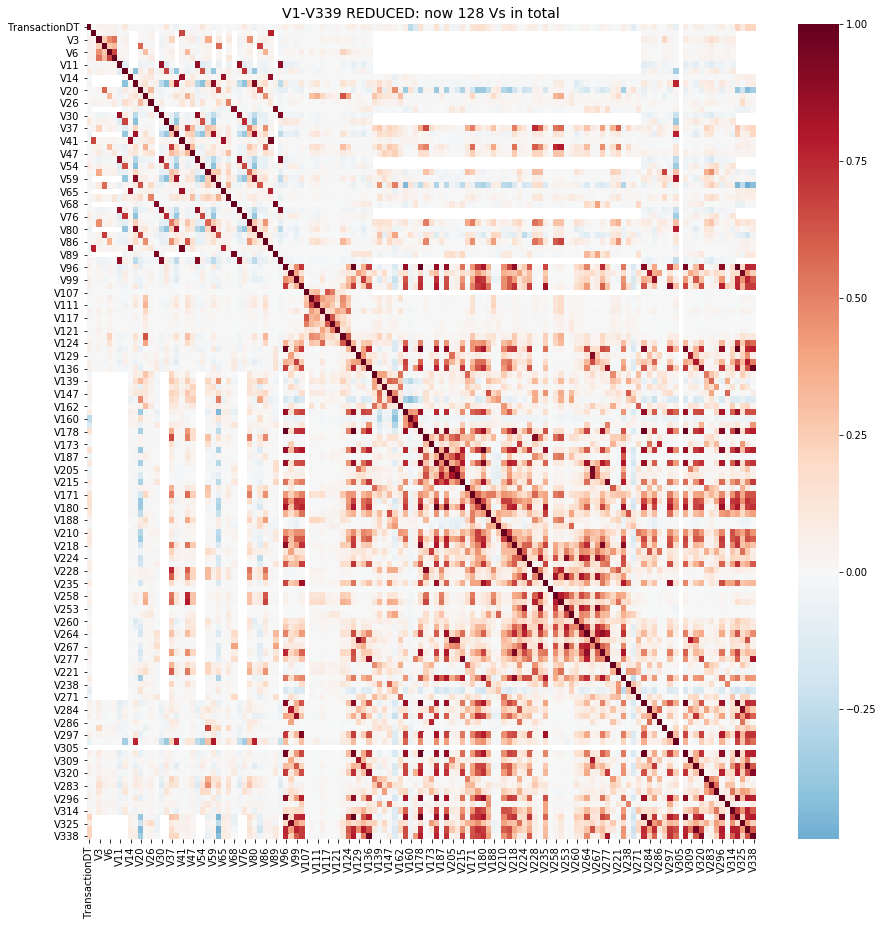

In [157]:
cols = ['TransactionDT'] +cols_use
train2 = train[cols].sample(frac=0.2)
plt.figure(figsize=(15,15))
sns.heatmap(train2[cols].corr(), cmap='RdBu_r', annot=False, center=0.0)
plt.title('V1-V339 REDUCED: now 128 Vs in total',fontsize=14)
plt.show()

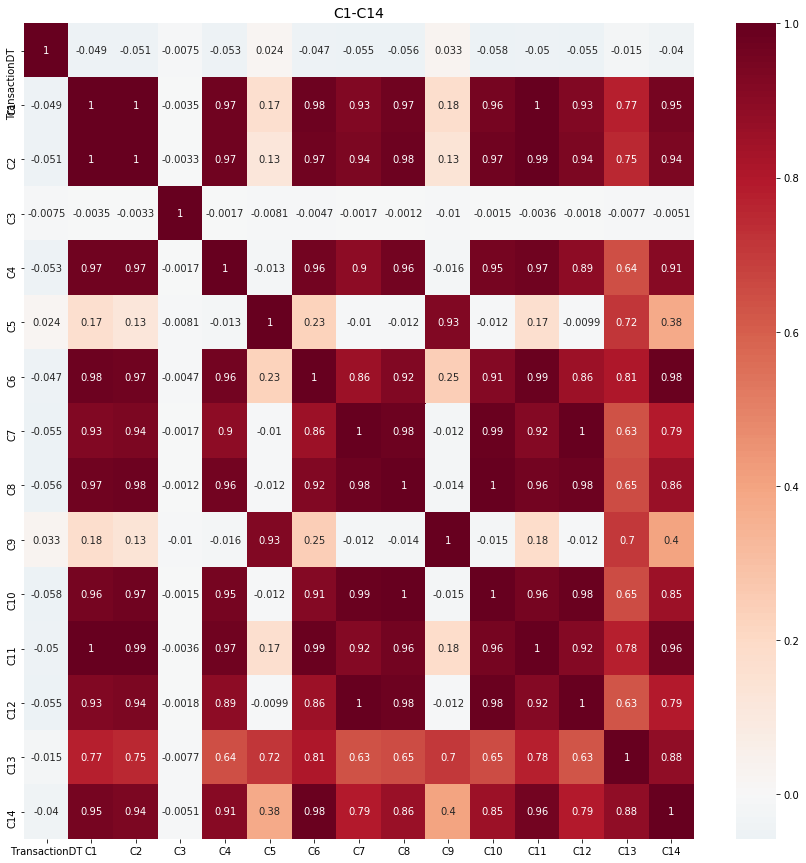

In [104]:
Vs=[ 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14']
Vtitle="C1-C14"
make_corr(Vs,Vtitle)

In [176]:
grps = [[1,2,4,6,7,8,10,11,12,14],[3],[5,9],[13]]
reduce_group(grps,c="C")

Use these ['C1', 'C3', 'C5', 'C13']


['V1',
 'V3',
 'V4',
 'V6',
 'V8',
 'V11',
 'V13',
 'V14',
 'V17',
 'V20',
 'V23',
 'V26',
 'V27',
 'V30',
 'V36',
 'V37',
 'V40',
 'V41',
 'V44',
 'V47',
 'V48',
 'V54',
 'V56',
 'V59',
 'V62',
 'V65',
 'V67',
 'V68',
 'V70',
 'V76',
 'V78',
 'V80',
 'V82',
 'V86',
 'V88',
 'V89',
 'V91',
 'V96',
 'V98',
 'V99',
 'V104',
 'V107',
 'V108',
 'V111',
 'V115',
 'V117',
 'V120',
 'V121',
 'V123',
 'V124',
 'V127',
 'V129',
 'V130',
 'V136',
 'V138',
 'V139',
 'V142',
 'V147',
 'V156',
 'V162',
 'V165',
 'V160',
 'V166',
 'V178',
 'V176',
 'V173',
 'V182',
 'V187',
 'V203',
 'V205',
 'V207',
 'V215',
 'V169',
 'V171',
 'V175',
 'V180',
 'V185',
 'V188',
 'V198',
 'V210',
 'V209',
 'V218',
 'V223',
 'V224',
 'V226',
 'V228',
 'V229',
 'V235',
 'V240',
 'V258',
 'V257',
 'V253',
 'V252',
 'V260',
 'V261',
 'V264',
 'V266',
 'V267',
 'V274',
 'V277',
 'V220',
 'V221',
 'V234',
 'V238',
 'V250',
 'V271',
 'V294',
 'V284',
 'V285',
 'V286',
 'V291',
 'V297',
 'V303',
 'V305',
 'V307',
 'V309',
 

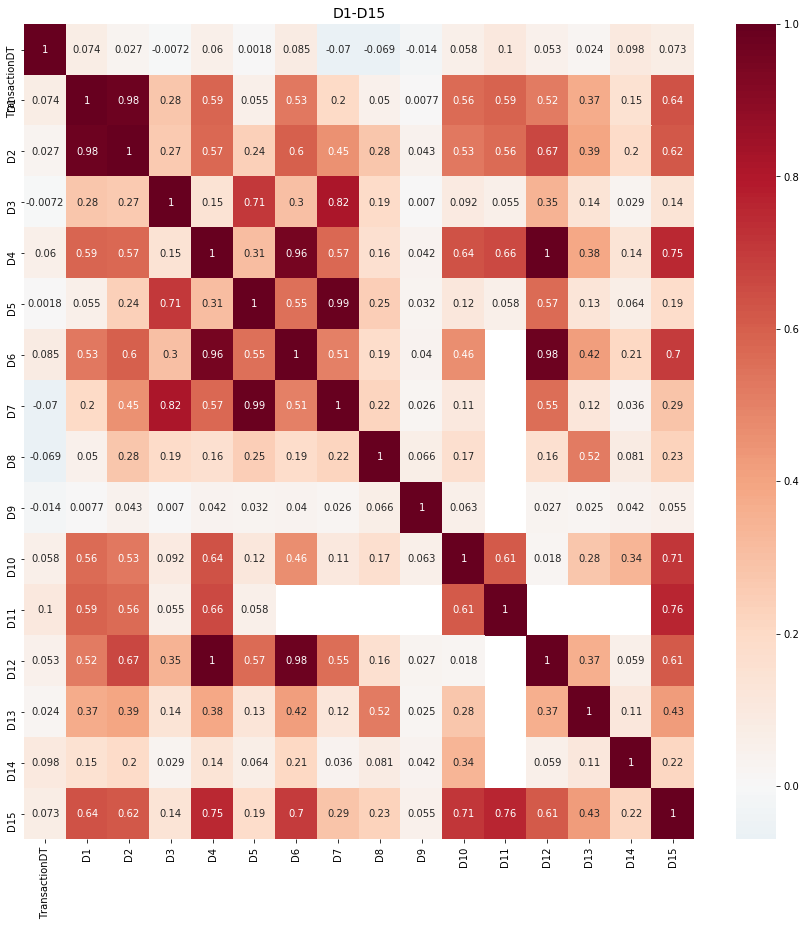

In [105]:
Vs=ds
Vtitle="D1-D15"
make_corr(Vs,Vtitle)

In [177]:
grps = [[1,2],[4,6,12],[3],[5,7],[8],[9],[10],[11],[13],[14],[15]]
reduce_group(grps,c="D")

Use these ['D1', 'D6', 'D3', 'D5', 'D8', 'D9', 'D10', 'D11', 'D13', 'D14', 'D15']


['V1',
 'V3',
 'V4',
 'V6',
 'V8',
 'V11',
 'V13',
 'V14',
 'V17',
 'V20',
 'V23',
 'V26',
 'V27',
 'V30',
 'V36',
 'V37',
 'V40',
 'V41',
 'V44',
 'V47',
 'V48',
 'V54',
 'V56',
 'V59',
 'V62',
 'V65',
 'V67',
 'V68',
 'V70',
 'V76',
 'V78',
 'V80',
 'V82',
 'V86',
 'V88',
 'V89',
 'V91',
 'V96',
 'V98',
 'V99',
 'V104',
 'V107',
 'V108',
 'V111',
 'V115',
 'V117',
 'V120',
 'V121',
 'V123',
 'V124',
 'V127',
 'V129',
 'V130',
 'V136',
 'V138',
 'V139',
 'V142',
 'V147',
 'V156',
 'V162',
 'V165',
 'V160',
 'V166',
 'V178',
 'V176',
 'V173',
 'V182',
 'V187',
 'V203',
 'V205',
 'V207',
 'V215',
 'V169',
 'V171',
 'V175',
 'V180',
 'V185',
 'V188',
 'V198',
 'V210',
 'V209',
 'V218',
 'V223',
 'V224',
 'V226',
 'V228',
 'V229',
 'V235',
 'V240',
 'V258',
 'V257',
 'V253',
 'V252',
 'V260',
 'V261',
 'V264',
 'V266',
 'V267',
 'V274',
 'V277',
 'V220',
 'V221',
 'V234',
 'V238',
 'V250',
 'V271',
 'V294',
 'V284',
 'V285',
 'V286',
 'V291',
 'V297',
 'V303',
 'V305',
 'V307',
 'V309',
 

In [164]:
train_transaction[ms].head(5)

,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,T,T,T,M2,F,T,NaN,NaN,NaN
1,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN
2,T,T,T,M0,F,F,F,F,F
3,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [175]:
train_transaction["M9"].value_counts()

T    205656
F     38632
Name: M9, dtype: int64

In [167]:
train_transaction["M4"].value_counts()

M0    196405
M2     59865
M1     52826
Name: M4, dtype: int64

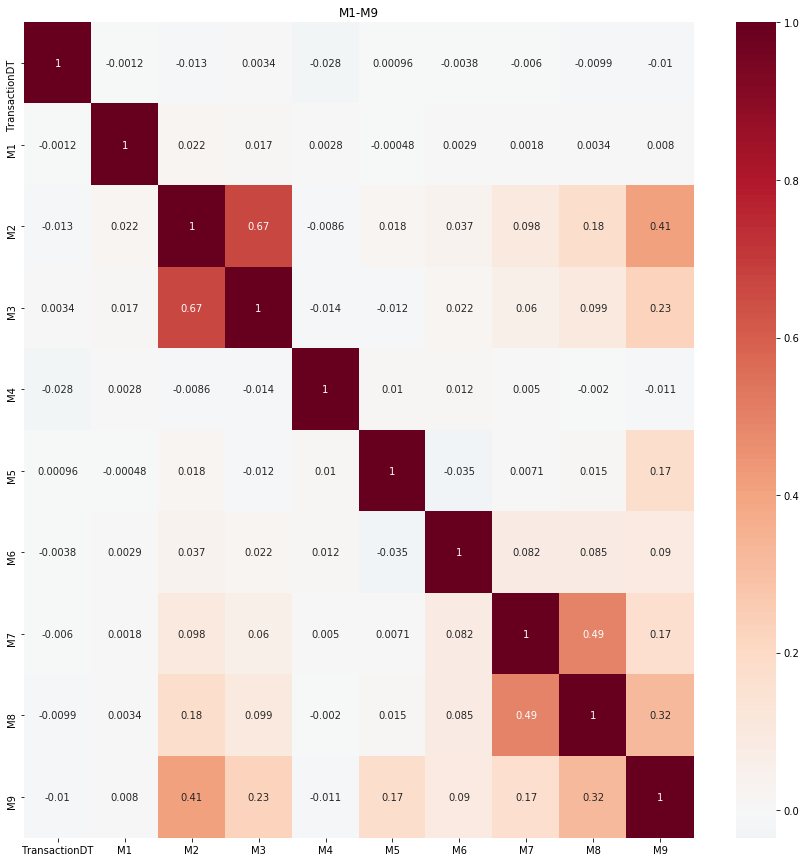

In [159]:
Ms = ['M'+str(x) for x in range(1,10)]
mp = {'F':0,'T':1,'M0':0,'M1':1,'M2':2}
for c in Ms: train[c] = train[c].map(mp)
cols = ['TransactionDT'] + Ms
plt.figure(figsize=(15,15))
sns.heatmap(train[cols].corr(), cmap='RdBu_r', annot=True, center=0.0)
plt.title('M1-M9')
plt.show()

In [178]:
# Categorical Features:
# ProductCD
# card1 - card6
# addr1, addr2
# Pemaildomain Remaildomain
# M1 - M9
# TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
# TransactionAMT: transaction payment amount in USD
# ProductCD: product code, the product for each transaction
# card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
# addr: address
# dist: distance
# P_ and (R__) emaildomain: purchaser and recipient email domain
# C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
# D1-D15: timedelta, such as days between previous transaction, etc.
# M1-M9: match, such as names on card and address, etc.
# Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.

In [378]:
print(len(cols_use))
id_str=['id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30','id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']
ids = ['id'+"_0"+str(x) for x in range(1,10)]+['id'+"_"+str(x) for x in range(10,39)]
for i in id_str:
    ids.remove(i)
cols_use=cols_use+['card1', 'card2', 'card3', 'card5']+ids


143


In [376]:
# cols_use is numerical
str_type = ['ProductCD', 'card4', 'card6', 'addr1', 'addr2', 'dist1', 'dist2','P_emaildomain', 'R_emaildomain','M1', 'M2', 'M3', 'M4','M5',
            'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 
            'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']

In [679]:
# we want to use: cols_use+str_type+['TransactionID', 'TransactionDT', 'TransactionAmt']
# X_train=all_train[cols_use+str_type+['TransactionID', 'TransactionDT', 'TransactionAmt']]
# X_train.shape
all_df2=all_df[cols_use+str_type+['TransactionID', 'TransactionDT', 'TransactionAmt']]
all_df2.shape

(1097231, 208)

In [201]:
# train=train_transaction[cols_use+ms+['TransactionID', 'TransactionDT', 'TransactionAmt',
#        'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
#        'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain','isFraud']]
# train.shape

(590540, 169)

In [380]:
# X_train['ProductCD'].value_counts()

W    439670
C     68519
R     37699
H     33024
S     11628
Name: ProductCD, dtype: int64

In [381]:
# X_train['card4'].value_counts()

visa                384767
mastercard          189217
american express      8328
discover              6651
Name: card4, dtype: int64

In [382]:
# X_train['card6'].value_counts()

debit              439938
credit             148986
debit or credit        30
charge card            15
Name: card6, dtype: int64

In [383]:
# Ms = ['M'+str(x) for x in range(1,10)]
# mp_m = {'F':0,'T':1,'M0':0,'M1':1,'M2':2}
# for c in Ms: X_train[c] = X_train[c].map(mp_m)
    
# mp_cd={'W':0,'C':1,'R':2,'H':3,'S':4}
# X_train["ProductCD"] = X_train["ProductCD"].map(mp_cd)

# mp_cd1={'visa':0,'mastercard':1,'american express':2,'discover':3}
# X_train["card4"] = X_train["card4"].map(mp_cd1)

# mp_cd2={'debit':0,'credit':1,'debit or credit':2,'charge card':3}
# X_train["card6"] = X_train["card6"].map(mp_cd2)

In [384]:
# X_train['ProductCD'].value_counts()

0    439670
1     68519
2     37699
3     33024
4     11628
Name: ProductCD, dtype: int64

In [680]:
temp=all_df2['R_emaildomain'].value_counts().to_dict()
temp

{'gmail.com': 118885,
 'hotmail.com': 53166,
 'anonymous.com': 39644,
 'yahoo.com': 21405,
 'aol.com': 7239,
 'outlook.com': 5011,
 'comcast.net': 3513,
 'icloud.com': 2820,
 'yahoo.com.mx': 2743,
 'msn.com': 1698,
 'live.com.mx': 1464,
 'live.com': 1444,
 'verizon.net': 1202,
 'sbcglobal.net': 1163,
 'me.com': 1095,
 'att.net': 870,
 'cox.net': 854,
 'outlook.es': 853,
 'bellsouth.net': 795,
 'hotmail.fr': 667,
 'hotmail.es': 595,
 'web.de': 514,
 'mac.com': 430,
 'ymail.com': 405,
 'optonline.net': 350,
 'mail.com': 341,
 'hotmail.co.uk': 317,
 'yahoo.fr': 315,
 'prodigy.net.mx': 303,
 'gmx.de': 297,
 'charter.net': 263,
 'gmail': 196,
 'earthlink.net': 170,
 'embarqmail.com': 140,
 'yahoo.de': 139,
 'hotmail.de': 130,
 'rocketmail.com': 126,
 'yahoo.es': 124,
 'juno.com': 111,
 'frontier.com': 110,
 'live.fr': 105,
 'yahoo.co.jp': 104,
 'windstream.net': 104,
 'roadrunner.com': 101,
 'yahoo.co.uk': 82,
 'servicios-ta.com': 80,
 'aim.com': 77,
 'protonmail.com': 75,
 'ptd.net': 70,
 

In [681]:
all_df2['R_dmail_count']=all_df2['R_emaildomain'].map(temp)

temp=all_df2['P_emaildomain'].value_counts().to_dict()
all_df2['P_dmail_count']=all_df2['P_emaildomain'].map(temp)

temp=all_df2["DeviceInfo"].value_counts().to_dict()
all_df2['DeviceInfo_count']=all_df2['DeviceInfo'].map(temp)

temp=all_df2["id_30"].value_counts().to_dict()
all_df2['id_30_count']=all_df2['id_30'].map(temp)

temp=all_df2["id_31"].value_counts().to_dict()
all_df2['id_31_count']=all_df2['id_31'].map(temp)

In [386]:
X_train['R_emaildomain'].value_counts()

gmail.com           57147
hotmail.com         27509
anonymous.com       20529
yahoo.com           11842
aol.com              3701
outlook.com          2507
comcast.net          1812
yahoo.com.mx         1508
icloud.com           1398
msn.com               852
live.com              762
live.com.mx           754
verizon.net           620
me.com                556
sbcglobal.net         552
cox.net               459
outlook.es            433
att.net               430
bellsouth.net         422
hotmail.fr            293
hotmail.es            292
web.de                237
mac.com               218
ymail.com             207
prodigy.net.mx        207
optonline.net         187
gmx.de                147
yahoo.fr              137
charter.net           127
mail.com              122
hotmail.co.uk         105
gmail                  95
earthlink.net          79
yahoo.de               75
rocketmail.com         69
embarqmail.com         68
scranton.edu           63
yahoo.es               57
live.fr     

In [388]:
# X_train[["R_emaildomain","isFraud"]][X_train["R_emaildomain"]!=np.nan].groupby(["R_emaildomain","isFraud"]).count()

In [389]:
# train[["P_emaildomain","isFraud"]][train["P_emaildomain"]!=np.nan].groupby(["P_emaildomain","isFraud"]).count()

In [ ]:
# gmail.com           57147
# hotmail.com         27509
# anonymous.com       20529
# yahoo.com           11842
# aol.com              3701
# outlook.com          2507
# comcast.net          1812
# yahoo.com.mx         1508
# icloud.com           1398
# gmail.com           228355
# yahoo.com           100934
# hotmail.com          45250
# anonymous.com        36998
# aol.com              28289
# comcast.net           7888
# icloud.com            6267
# outlook.com           5096
# msn.com               4092
# att.net               4033
# live.com              3041
# sbcglobal.net         2970
# verizon.net           2705
# ymail.com             2396

In [682]:
domain_list=["gmail","hotmail","anonymous","yahoo","aol.com","outlook","comcast","icloud"]
def emil_do(s,domain_list):
    s=str(s)
    for l in domain_list:
        if l in s:
            return l

In [683]:
all_df2["P_dmail"]=all_df2["P_emaildomain"].map(lambda x: emil_do(x,domain_list))
all_df2["R_dmail"]=all_df2["R_emaildomain"].map(lambda x: emil_do(x,domain_list))

In [663]:
all_df2["P_dmail"].value_counts()

gmail        436796
yahoo        186568
hotmail       87414
anonymous     71062
aol.com       52337
comcast       14474
icloud        12316
outlook       10797
Name: P_dmail, dtype: int64

In [664]:
id_str=['id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30','id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']
for id in id_str:
    print(all_df2[id].value_counts())

NotFound    243920
Found        42220
Name: id_12, dtype: int64
Found      135690
New        119397
Unknown     22875
Name: id_15, dtype: int64
Found       132805
NotFound    122282
Name: id_16, dtype: int64
IP_PROXY:TRANSPARENT    7203
IP_PROXY:ANONYMOUS      2010
IP_PROXY:HIDDEN         1018
Name: id_23, dtype: int64
Found       10214
NotFound       17
Name: id_27, dtype: int64
Found    151813
New      125943
Name: id_28, dtype: int64
Found       149264
NotFound    128492
Name: id_29, dtype: int64
Windows 10          42170
Windows 7           23478
iOS 12.1.0           6349
Mac OS X 10_12_6     3884
iOS 11.2.1           3824
Mac OS X 10_11_6     3802
iOS 11.1.2           3776
Android 7.0          3573
iOS 11.4.1           3539
Windows 8.1          3308
Mac OS X 10_13_6     3254
Android 8.0.0        2798
iOS 11.3.0           2662
Mac OS X 10_10_5     2575
Linux                2488
iOS 10.3.3           2043
Android              1848
iOS 11.2.6           1834
iOS 12.0.1           1691
i

In [665]:
all_df2["DeviceInfo"].value_counts()

Windows                           92710
iOS Device                        38502
MacOS                             23722
Trident/7.0                       12330
rv:11.0                            2650
SM-G532M Build/MMB29T               980
rv:57.0                             968
SM-J700M Build/MMB29K               829
SM-G610M Build/MMB29K               804
SM-G531H Build/LMY48B               682
rv:63.0                             474
ALE-L23 Build/HuaweiALE-L23         458
SM-G935F Build/NRD90M               450
SAMSUNG                             445
rv:61.0                             421
rv:52.0                             378
rv:59.0                             376
rv:62.0                             335
SM-G955U Build/NRD90M               334
Moto G (4) Build/NPJ25.93-14.7      326
SM-J730GM Build/NRD90M              319
ANE-LX3                             315
rv:64.0                             310
SM-G950U Build/NRD90M               308
LG-M700 Build/NMF26X                300


In [684]:
def device_trans(input_str):
    input_str=str(input_str).lower()
    if input_str=="nan":
        return "NAN"
    elif input_str[:3]=="ios":
        return "IOS"
    elif input_str[:7]=="windows":
        return "Windows" 
    elif input_str[:3]=="sm-" or input_str[:7]=="samsung":
        return "SM" 
    elif input_str[:7]=="trident":
        return "Trident"  
    elif input_str[:2]=="lg":
        return "LG" 
    elif input_str[:3]=="rv:":
        return "rv" 
    elif input_str[:4]=="moto":
        return "Moto"
    elif input_str[:5]=="macos":
        return "MacOS" 
    elif "huawei" in input_str:
        return "HUAWEI"
    else:
        return "else"
all_df2["DeviceInfo_1"]=all_df2["DeviceInfo"].map(device_trans)

In [685]:
all_df2["DeviceInfo_1"].value_counts()

NAN        863508
Windows     92763
IOS         38502
SM          25047
MacOS       23722
else        16245
Trident     12330
Moto         8155
rv           7197
HUAWEI       4916
LG           4846
Name: DeviceInfo_1, dtype: int64

In [686]:
def id_30_map(input_str):
    input_str=str(input_str).lower()
    if input_str=="nan":
        return "NAN"    
    elif input_str[:7]=="windows":
        return "windows"
    elif input_str[:3]=="ios":
        return "ios"
    elif input_str[:3]=="mac":
        return "mac"
    elif input_str[:7]=="android":
        return "andriod"
    elif input_str[:5]=="linux":
        return "linux"
    else:
        return "else"
    
all_df2["id_30_1"]=all_df2["id_30"].map(id_30_map)
all_df2["id_30_1"].value_counts()

NAN        949007
windows     69777
ios         38502
mac         25634
andriod     11783
linux        2488
else           40
Name: id_30_1, dtype: int64

In [687]:
 def id_31_map(input_str):
    input_str=str(input_str).lower()
    if input_str=="nan":
        return "NAN"  
    elif input_str[:7]=="firefox":
        return "firefox"
    elif input_str[:7]=="android":
        return "android"
    elif input_str[:7]=="samsung":
        return "samsung"
    elif input_str[:6]=="chrome":
        return "chrome"
    elif input_str[:6]=="google":
        return "google"
    elif input_str[:2]=="ie":
        return "ie"
    elif input_str[:6]=="mobile":
        return "mobile"
    elif input_str[:5]=="opera":
        return "opera"
    elif input_str[:6]=="safari":
        return "safari"
    elif input_str[:4]=="edge":
        return "edge"
    else:
        return "else"
    
all_df2["id_31_1"]=all_df2["id_31"].map(id_31_map)
all_df2["id_31_1"].value_counts()

NAN        820324
chrome     155502
mobile      53259
safari      16625
ie          15603
firefox     14388
edge        11985
samsung      4787
google       2146
android      1051
opera         843
else          718
Name: id_31_1, dtype: int64

In [688]:
id_str2=['id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']
 # exclude 'id_30','id_31'
for id in id_str2:
    all_df2[id]=all_df2[id].factorize(sort=True)[0]
all_df2["DeviceType"]=all_df2["DeviceType"].factorize(sort=True)[0]
all_df2["DeviceInfo_2"]=all_df2["DeviceInfo_1"].factorize(sort=True)[0]
all_df2["id_30_2"]=all_df2["id_30_1"].factorize(sort=True)[0]
all_df2["id_31_2"]=all_df2["id_31_1"].factorize(sort=True)[0]

In [689]:
all_df2["P_dmail_num"]=all_df2["P_dmail"].factorize(sort=True)[0]
all_df2["R_dmail_num"]=all_df2["R_dmail"].factorize(sort=True)[0]         
all_df2["ProductCD"]=all_df2["ProductCD"].factorize(sort=True)[0]
all_df2["card4"]=all_df2["card4"].factorize(sort=True)[0] 
all_df2["card6"]=all_df2["card6"].factorize(sort=True)[0] 
    
Ms = ['M'+str(x) for x in range(1,10)]
mp_m = {'F':0,'T':1,'M0':0,'M1':1,'M2':2}
for c in Ms: all_df2[c] = all_df2[c].map(mp_m)


In [690]:
all_df2.head(5)

,V1,V3,V4,V6,V8,V11,V13,V14,V17,V20,...,P_dmail,R_dmail,DeviceInfo_1,id_30_1,id_31_1,DeviceInfo_2,id_30_2,id_31_2,P_dmail_num,R_dmail_num
0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,...,None,None,NAN,NAN,NAN,5,0,0,-1,-1
1,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,1.0,...,gmail,None,NAN,NAN,NAN,5,0,0,3,-1
2,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,...,outlook,None,NAN,NAN,NAN,5,0,0,6,-1
3,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,1.0,...,yahoo,None,NAN,NAN,NAN,5,0,0,7,-1
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,gmail,None,SM,andriod,samsung,6,1,11,3,-1


In [691]:
all_df2["addr"]=all_df2["addr1"].astype(str)+"_"+all_df2["addr2"].astype(str)
all_df2.head(5)

,V1,V3,V4,V6,V8,V11,V13,V14,V17,V20,...,R_dmail,DeviceInfo_1,id_30_1,id_31_1,DeviceInfo_2,id_30_2,id_31_2,P_dmail_num,R_dmail_num,addr
0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,...,None,NAN,NAN,NAN,5,0,0,-1,-1,315.0_87.0
1,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,1.0,...,None,NAN,NAN,NAN,5,0,0,3,-1,325.0_87.0
2,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,...,None,NAN,NAN,NAN,5,0,0,6,-1,330.0_87.0
3,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,1.0,...,None,NAN,NAN,NAN,5,0,0,7,-1,476.0_87.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,SM,andriod,samsung,6,1,11,3,-1,420.0_87.0


In [493]:
all_df2["id_19"].dtype

dtype('float64')

In [692]:
cols_D=['D1',
 'D6',
 'D3',
 'D5',
 'D8',
 'D9',
 'D10',
 'D11',
 'D13',
 'D14',
 'D15']
for col in cols_D: 
    new_col = 'uid_td_'+str(col)
    
    all_df2[new_col] = all_df2['TransactionDT'] / (24*60*60)
    all_df2[new_col] = np.floor(all_df2[new_col] - all_df2[col]) + 1000
all_df2['DT_day'] = np.floor(all_df2['TransactionDT']/(24*60*60)) + 1000
all_df2["count0"]=all_df2.groupby(["addr","card1","uid_td_D1"])["TransactionID"].transform('count')
all_df2["count1"]=all_df2.groupby(["addr1","card1","uid_td_D1"])["TransactionID"].transform('count')
all_df2["count2"]=all_df2.groupby(["addr1","card1","P_emaildomain","uid_td_D1"])["TransactionID"].transform('count')
all_df2["count3"]=all_df2.groupby(["addr1","card1","P_emaildomain","uid_td_D1"])["TransactionAmt"].transform('mean')
all_df2["count4"]=all_df2.groupby(["addr1","card1","P_emaildomain","uid_td_D1"])["TransactionAmt"].transform('sum')

In [693]:
all_df2=all_df2.drop(['TransactionDT',"P_emaildomain","R_emaildomain","P_dmail","R_dmail","addr1","addr2","addr","DeviceInfo_1","DeviceInfo","id_30_1","id_30","id_31_1","id_31"]+cols_D,axis=1)
all_df2.head(5)

,V1,V3,V4,V6,V8,V11,V13,V14,V17,V20,...,uid_td_D11,uid_td_D13,uid_td_D14,uid_td_D15,DT_day,count0,count1,count2,count3,count4
0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,...,988.0,NaN,NaN,1001.0,1001.0,1.0,1.0,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,1.0,...,NaN,NaN,NaN,1001.0,1001.0,1.0,1.0,1.0,29.000000,29.0
2,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,...,686.0,NaN,NaN,686.0,1001.0,4.0,4.0,4.0,73.500000,294.0
3,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,1.0,...,NaN,NaN,NaN,890.0,1001.0,84.0,84.0,84.0,66.392857,5577.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1001.0,1.0,1.0,1.0,50.000000,50.0


In [694]:
cols=all_df2.columns
X_train=all_df2.iloc[:590540,:]
X_test=all_df2.iloc[590540:,:]

In [695]:
for col in cols:
    print(col,all_df2[col].dtype)

V1 float64
V3 float64
V4 float64
V6 float64
V8 float64
V11 float64
V13 float64
V14 float64
V17 float64
V20 float64
V23 float64
V26 float64
V27 float64
V30 float64
V36 float64
V37 float64
V40 float64
V41 float64
V44 float64
V47 float64
V48 float64
V54 float64
V56 float64
V59 float64
V62 float64
V65 float64
V67 float64
V68 float64
V70 float64
V76 float64
V78 float64
V80 float64
V82 float64
V86 float64
V88 float64
V89 float64
V91 float64
V96 float64
V98 float64
V99 float64
V104 float64
V107 float64
V108 float64
V111 float64
V115 float64
V117 float64
V120 float64
V121 float64
V123 float64
V124 float64
V127 float64
V129 float64
V130 float64
V136 float64
V138 float64
V139 float64
V142 float64
V147 float64
V156 float64
V162 float64
V165 float64
V160 float64
V166 float64
V178 float64
V176 float64
V173 float64
V182 float64
V187 float64
V203 float64
V205 float64
V207 float64
V215 float64
V169 float64
V171 float64
V175 float64
V180 float64
V185 float64
V188 float64
V198 float64
V210 float64
V209 

In [588]:
def check_group(df,uid):
    bad_uids=df.groupby(uid)["isFraud"].agg(['nunique', 'count'] )   
    bad_uids = bad_uids[(bad_uids['nunique']==2)]
    print('Inconsistent groups',len(bad_uids))
     
    print('Cleaning done...')
    print(#'Total groups:', len(df[uid].unique()), 
          '| Total items:', len(df),
          '| Total fraud', df['isFraud'].sum())
    

In [603]:
X_train_tt=pd.concat([X_train,y_train[['isFraud']]],axis=1)
X_train_tt.shape    

(590540, 210)

In [581]:
train_transaction[['TransactionID']].agg("nunique")

TransactionID    590540
dtype: int64

In [582]:
X_train_tt[['TransactionID']].agg("nunique")

TransactionID    590540
dtype: int64

In [604]:
X_train_tt=pd.merge(X_train_tt,train_transaction[['TransactionID','addr1',"addr2","P_emaildomain","R_emaildomain"]],on="TransactionID",how="left")
X_train_tt.shape  

(590540, 214)

In [595]:
check_group(df=X_train_tt,uid=["addr1","card1","uid_td_D1"])

Inconsistent groups 1232
Cleaning done...
| Total items: 590540 | Total fraud 20663


In [596]:
check_group(df=X_train_tt,uid=["addr1","addr2","card1","uid_td_D1"])

Inconsistent groups 1231
Cleaning done...
| Total items: 590540 | Total fraud 20663


In [597]:
check_group(df=X_train_tt,uid=["addr1","card1","P_dmail_num","uid_td_D1"])

Inconsistent groups 683
Cleaning done...
| Total items: 590540 | Total fraud 20663


In [606]:
check_group(df=X_train_tt,uid=["addr1","P_emaildomain","uid_td_D1"])

Inconsistent groups 2851
Cleaning done...
| Total items: 590540 | Total fraud 20663


In [601]:
check_group(df=X_train_tt,uid=["addr1","card1","P_dmail_num","uid_td_D3"])

Inconsistent groups 959
Cleaning done...
| Total items: 590540 | Total fraud 20663


In [608]:
check_group(df=X_train_tt,uid=["addr1","card1","R_emaildomain","uid_td_D1"])

Inconsistent groups 117
Cleaning done...
| Total items: 590540 | Total fraud 20663


In [611]:
check_group(df=X_train_tt,uid=["addr1","addr2","card1","R_emaildomain","uid_td_D1"])

Inconsistent groups 117
Cleaning done...
| Total items: 590540 | Total fraud 20663


In [615]:
check_group(df=X_train_tt,uid=["addr1","addr2","card1","card2","card3","card4","card5","card6","R_emaildomain","uid_td_D1"])

Inconsistent groups 113
Cleaning done...
| Total items: 590540 | Total fraud 20663


In [696]:
#TRAIN 75% PREDICT 25%
num=3*len(X_train)//4
idxT = X_train.index[:num] #0~442904
idxV = X_train.index[num:]#442905~590539

In [697]:
y_train.loc[idxV,"isFraud"].values

array([0, 0, 0, ..., 0, 0, 0])

In [708]:
dtrain= xgb.DMatrix(X_train.loc[idxT,cols].values,label=y_train.loc[idxT,"isFraud"].values)
dtest= xgb.DMatrix(X_train.loc[idxV,cols].values,label=y_train.loc[idxV,"isFraud"].values)
param = {'max_depth':12, 'eta':0.1, 'silent':1, 'nthread':24,'objective':'binary:logistic',#'reg:linear',#'multi:softmax',#'binary:logistic',
         'lambda':1.0,'min_child_weight':300,'colsample_bytree':0.4,'eval_metric':'auc',
         'scale_pos_weight':1,'subsample':0.8}                    
plst=param.items()
watchlist = [(dtrain, 'ins'),(dtest, 'oos')]
evals_result={}
num_rounds=2000
model  = xgb.train(plst,dtrain,num_rounds,evals=watchlist,early_stopping_rounds=200,evals_result=evals_result,verbose_eval=50)

[0]	ins-auc:0.846758	oos-auc:0.82124
Multiple eval metrics have been passed: 'oos-auc' will be used for early stopping.

Will train until oos-auc hasn't improved in 200 rounds.
[50]	ins-auc:0.902289	oos-auc:0.872426
[100]	ins-auc:0.918628	oos-auc:0.884771
[150]	ins-auc:0.926651	oos-auc:0.890118
[200]	ins-auc:0.931991	oos-auc:0.893351
[250]	ins-auc:0.936411	oos-auc:0.896635
[300]	ins-auc:0.939799	oos-auc:0.899072
[350]	ins-auc:0.943021	oos-auc:0.900542
[400]	ins-auc:0.945364	oos-auc:0.900989
[450]	ins-auc:0.947823	oos-auc:0.902912
[500]	ins-auc:0.949751	oos-auc:0.904054
[550]	ins-auc:0.951547	oos-auc:0.905211
[600]	ins-auc:0.953295	oos-auc:0.905721
[650]	ins-auc:0.954707	oos-auc:0.906274
[700]	ins-auc:0.956141	oos-auc:0.907032
[750]	ins-auc:0.957471	oos-auc:0.907617
[800]	ins-auc:0.958657	oos-auc:0.907999
[850]	ins-auc:0.959684	oos-auc:0.908497
[900]	ins-auc:0.960788	oos-auc:0.908786
[950]	ins-auc:0.961856	oos-auc:0.909239
[1000]	ins-auc:0.962767	oos-auc:0.909822
[1050]	ins-auc:0.963531

In [713]:
dtrain= xgb.DMatrix(X_train.drop(["TransactionID"],axis=1).loc[idxT,cols].values,label=y_train.loc[idxT,"isFraud"].values)
dtest= xgb.DMatrix(X_train.drop(["TransactionID"],axis=1).loc[idxV,cols].values,label=y_train.loc[idxV,"isFraud"].values)
param = {'max_depth':12, 'eta':0.15, 'silent':1, 'nthread':24,'objective':'binary:logistic',#'reg:linear',#'multi:softmax',#'binary:logistic',
         'lambda':1.0,'min_child_weight':300,'colsample_bytree':0.4,'eval_metric':'auc',
         'scale_pos_weight':1,'subsample':0.8}                    
plst=param.items()
watchlist = [(dtrain, 'ins'),(dtest, 'oos')]
evals_result={}
num_rounds=2000
model  = xgb.train(plst,dtrain,num_rounds,evals=watchlist,early_stopping_rounds=200,evals_result=evals_result,verbose_eval=50)

[0]	ins-auc:0.845376	oos-auc:0.820116
Multiple eval metrics have been passed: 'oos-auc' will be used for early stopping.

Will train until oos-auc hasn't improved in 200 rounds.
[50]	ins-auc:0.910718	oos-auc:0.879095
[100]	ins-auc:0.925621	oos-auc:0.890494
[150]	ins-auc:0.93395	oos-auc:0.893849
[200]	ins-auc:0.939529	oos-auc:0.897261
[250]	ins-auc:0.943741	oos-auc:0.89891
[300]	ins-auc:0.947296	oos-auc:0.900322
[350]	ins-auc:0.950247	oos-auc:0.902001
[400]	ins-auc:0.952853	oos-auc:0.903894
[450]	ins-auc:0.954972	oos-auc:0.904175
[500]	ins-auc:0.957078	oos-auc:0.90597
[550]	ins-auc:0.95872	oos-auc:0.906633
[600]	ins-auc:0.960454	oos-auc:0.906968
[650]	ins-auc:0.96186	oos-auc:0.907377
[700]	ins-auc:0.963278	oos-auc:0.908361
[750]	ins-auc:0.964435	oos-auc:0.908201
[800]	ins-auc:0.965509	oos-auc:0.908721
[850]	ins-auc:0.966641	oos-auc:0.909481
[900]	ins-auc:0.967609	oos-auc:0.909913
[950]	ins-auc:0.968543	oos-auc:0.910131
[1000]	ins-auc:0.969547	oos-auc:0.910309
[1050]	ins-auc:0.970317	oos

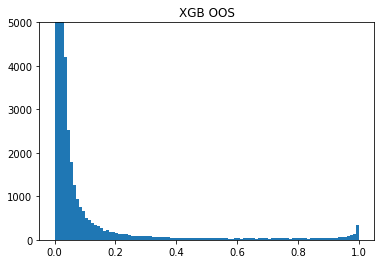

In [714]:
pred=model.predict(dtest)
plt.hist(pred,bins=100)
plt.ylim((0,5000))
plt.title('XGB OOS')
plt.show()

(<matplotlib.axes._subplots.AxesSubplot at 0x7f9ef315dc88>,)

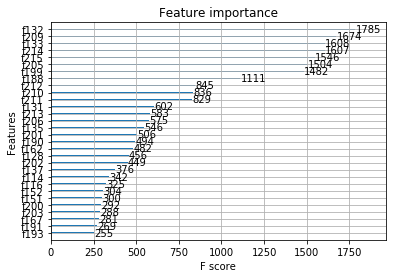

In [715]:
xgb.plot_importance(model,max_num_features=30,importance_type='weight'),